# Pix2Pix

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from PIL import Image
from datetime import datetime
import copy
import os
import random
import time
from tqdm import tqdm

Dataset Size: 50025
Image Shape: torch.Size([3, 64, 128])


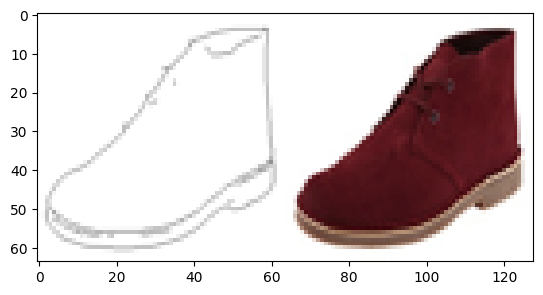

In [2]:
class CustomRandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, x):
        if random.random() < self.p:
            x[:, :, :x.shape[2]//2] = transforms.functional.hflip(x[:, :, :x.shape[2]//2])
            x[:, :, x.shape[2]//2:] = transforms.functional.hflip(x[:, :, x.shape[2]//2:])
        
        return x

transform = transforms.Compose([
    transforms.Resize((64, ), transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    CustomRandomHorizontalFlip()
])
img_folder_dataset = torchvision.datasets.ImageFolder(root='../../data/edges2shoes/', transform=transform)

print("Dataset Size:", len(img_folder_dataset))
print("Image Shape:", img_folder_dataset[1][0].shape)
plt.imshow(img_folder_dataset[1][0].permute(1, 2, 0));

In [3]:
class Edge2ShoesDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder_dataset: torchvision.datasets.ImageFolder, transform=None):
        self.img_folder_dataset = image_folder_dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.img_folder_dataset)
    
    def __getitem__(self, idx):
        edges, shoes = torch.chunk(self.img_folder_dataset[idx][0], 2, dim=2)
        if self.transform is not None:
            edges, shoes = self.transform(edges), self.transform(shoes)
        
        return edges, shoes

50025


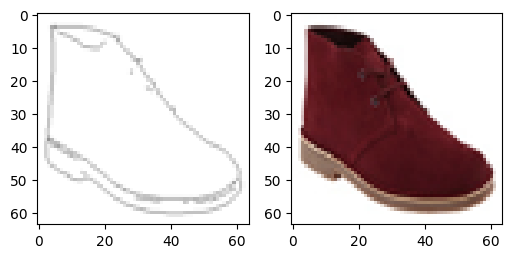

In [4]:
dataset = Edge2ShoesDataset(img_folder_dataset)

print(len(dataset))
_, axs = plt.subplots(1, 2, figsize=(6, 3))
edge, shoe = dataset[1]
axs[0].imshow(edge.permute(1, 2, 0))
axs[1].imshow(shoe.permute(1, 2, 0));

## Generator (U-Net)

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, use_dropout=False):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.Dropout() if use_dropout else nn.Identity(),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.Dropout() if use_dropout else nn.Identity(),
            nn.LeakyReLU(negative_slope=0.2),
        )

    def forward(self, x):
        return self.net(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, use_dropout=False):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, use_dropout)
        )
    
    def forward(self, x):
        return self.net(x)


class Up(nn.Module):
    def __init__(self, start_channels, out_channels):
        super().__init__()

        self.upsample = nn.ConvTranspose2d(start_channels, start_channels//2, kernel_size=2, stride=2)
        self.dconv = DoubleConv(start_channels, out_channels)
    
    def forward(self, input, skip):
        input = self.upsample(input)
        x = torch.cat([skip, input], dim=1)

        return self.dconv(x)


class UNet(nn.Module):
    def __init__(self, img_channels):
        super().__init__()

        self.dconv1 = DoubleConv(img_channels, out_channels=8)
        self.down1 = Down(in_channels=8, out_channels=16, use_dropout=True)
        self.down2 = Down(in_channels=16, out_channels=32, use_dropout=True)
        self.down3 = Down(in_channels=32, out_channels=64)
        self.down4 = Down(in_channels=64, out_channels=128)

        self.up1 = Up(start_channels=128, out_channels=64)
        self.up2 = Up(start_channels=64, out_channels=32)
        self.up3 = Up(start_channels=32, out_channels=16)
        self.up4 = Up(start_channels=16, out_channels=8)

        self.to_rgb = nn.Conv2d(in_channels=8, out_channels=img_channels, kernel_size=1)

    def forward(self, img):
        skip1 = self.dconv1(img)
        skip2 = self.down1(skip1)
        skip3 = self.down2(skip2)
        skip4 = self.down3(skip3)

        last_down_out = self.down4(skip4)

        out = self.up1(last_down_out, skip4)
        out = self.up2(out, skip3)
        out = self.up3(out, skip2)
        out = self.up4(out, skip1)

        out = self.to_rgb(out).sigmoid()

        return out


UNet(img_channels=3)(torch.randn(32, 3, 64, 64)).shape

torch.Size([32, 3, 64, 64])

## PatchGAN Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, hidden_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(input_channels, hidden_dim, kernel_size=1),
            Down(hidden_dim, hidden_dim*2),
            Down(hidden_dim*2, hidden_dim*4),
            Down(hidden_dim*4, hidden_dim*8),
            nn.Conv2d(hidden_dim*8, 1, kernel_size=1)
        )
    
    def forward(self, x, y):
        return self.net(torch.cat([x, y], dim=1))


Discriminator(input_channels=6, hidden_dim=10)(x=torch.randn(4, 3, 64, 64), y=torch.randn(4, 3, 64, 64)).shape

torch.Size([4, 1, 8, 8])

## Pix2Pix Loss

In [7]:
class Pix2PixLoss:
    def __init__(self, disc: Discriminator, lambda_reconstruction=200):
        self.disc = disc

        self.adv_criterion = nn.BCEWithLogitsLoss() 
        self.reconstruction_criterion = nn.L1Loss() 
        self.lambda_reconstruction = lambda_reconstruction
    
    def gen_loss(self, conditions, real_images, fake_images):
        fake_preds = self.disc(fake_images, conditions)

        adv_loss = self.adv_criterion(fake_preds, torch.ones_like(fake_preds))
        recon_loss = self.reconstruction_criterion(fake_images, real_images)

        return adv_loss + self.lambda_reconstruction * recon_loss

    def disc_loss(self, conditions, real_images, fake_images):
        real_preds = self.disc(real_images, conditions)
        fake_preds = self.disc(fake_images, conditions)

        loss = (self.adv_criterion(fake_preds, torch.zeros_like(fake_preds)) + self.adv_criterion(real_preds, torch.ones_like(real_preds))) / 2

        return loss
   

## Train

In [8]:
def generate_images_and_save(gen: UNet, data: list, epoch: int, path: str, device):
    
    os.makedirs(path, exist_ok=True)

    with torch.no_grad():
        edges = torch.stack([d[0] for d in data])
        shoes = torch.stack([d[1] for d in data])
        fake_images = gen(edges.to(device)).detach().cpu().clip(0, 1)
        _, C, H, W = shoes.shape
        imgs = torch.cat([edges.unsqueeze(1), shoes.unsqueeze(1), fake_images.unsqueeze(1)], dim=1).view(-1, C, H, W)
        imgs = torchvision.utils.make_grid(imgs, nrow=6)
        imgs = transforms.Resize(1500)(imgs).permute(1, 2, 0).numpy()
    
    filename = f"Epoch {epoch}.png"
    
    plt.imsave(os.path.join(path, filename), imgs)

In [9]:
def save_models_and_state(
    gen: UNet,
    crit: Discriminator,
    opt_gen: torch.optim.Adam,
    opt_crit: torch.optim.Adam,
    state: dict,
    path: str
):
    os.makedirs(path, exist_ok=True)
    
    torch.save(gen.state_dict(), os.path.join(path, 'gen.pth'))
    torch.save(crit.state_dict(), os.path.join(path, 'crit.pth'))
    torch.save(opt_gen.state_dict(), os.path.join(path, 'opt_gen.pth'))
    torch.save(opt_crit.state_dict(), os.path.join(path, 'opt_crit.pth'))
    torch.save(state, os.path.join(path, 'state.pth'))

In [10]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [11]:
BATCH_SIZE = 64
EPOCHS=50
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


In [12]:
gen = UNet(img_channels=3).to(device)
disc = Discriminator(input_channels=6, hidden_dim=8).to(device)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

opt_gen = torch.optim.Adam(gen.parameters(), lr=0.0002)
opt_disc = torch.optim.Adam(disc.parameters(), lr=0.0002)

loss_calculator = Pix2PixLoss(disc)

In [13]:
from_checkpoint = True

if from_checkpoint:
    state_root = 'results/'

    gen.load_state_dict(torch.load(os.path.join(state_root, 'gen.pth')))
    disc.load_state_dict(torch.load(os.path.join(state_root, 'crit.pth')))
    opt_gen.load_state_dict(torch.load(os.path.join(state_root, 'opt_gen.pth')))
    opt_disc.load_state_dict(torch.load(os.path.join(state_root, 'opt_crit.pth')))

    state = torch.load(os.path.join(state_root, 'state.pth'))
else:
    state = {}

state

{'epoch': 199}

In [23]:
eval_data = [dataset[i] for i in range(12)]

for epoch in range(EPOCHS):
    epoch_start_time = time.time()

    for edges, shoes in dataloader:
        edges, shoes = edges.to(device), shoes.to(device)
        
        #----- Updating the Discriminator -----#
        fake_images = gen(edges).detach()
        loss = loss_calculator.disc_loss(edges, shoes, fake_images)
        opt_disc.zero_grad()
        loss.backward(retain_graph=True)
        opt_disc.step()

        #----- Updating the Generator -----#
        fake_images = gen(edges)
        loss = loss_calculator.gen_loss(edges, shoes, fake_images)
        opt_gen.zero_grad()
        loss.backward()
        opt_gen.step()
    
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Epoch {epoch} [Epoch time: {time.time() - epoch_start_time}]")
    generate_images_and_save(gen, data=eval_data, epoch=epoch, path='results', device=device)
    save_models_and_state(gen, disc, opt_gen, opt_disc, {"epoch": epoch}, 'results/')

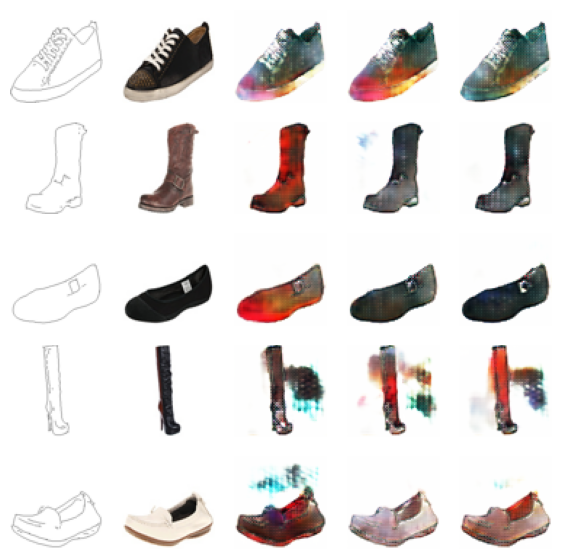

In [19]:
cnt_visualization = 5
cnt_generation = 3

_, axs = plt.subplots(cnt_visualization, 2+cnt_generation, figsize=(7, 7))
for i, idx in enumerate(torch.randperm(len(dataset))[:cnt_visualization]):
    for j in range(len(axs[0])):
        axs[i][j].axis('off')
    edge, shoe = dataset[idx]
    axs[i][0].imshow(edge.permute(1, 2, 0))
    axs[i][1].imshow(shoe.permute(1, 2, 0))
    generated_images = gen(edge.unsqueeze(0).expand(cnt_generation, -1, -1, -1).to(device)).detach().cpu().clip(0, 1)
    for j, gen_img in enumerate(generated_images):
        axs[i][j+2].imshow(gen_img.permute(1, 2, 0))
